In [2]:
# Configuration OpenMP
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import importlib
from torch.utils.data import Dataset, DataLoader, random_split

# Imports des modules locaux
from data_loading import *
from models import *
from training import *
from visualization import *
from evaluation import *

print("✓ Modules rechargés avec succès")

✓ Modules rechargés avec succès


### Env configuration

In [14]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device used: {device}")

# Data path configuration
project_root = Path(os.getcwd()).parent  # go back from modular -> NFTM_for_Physic -> NFTM
data_dir = project_root / "Data"
print(f"Data directory: {data_dir}")

models_dir = project_root / "saved_models"

WINDOW_SIZE = 10

# Check file existence
# files_burger = {
#     0.001: data_dir / "100traj_burgers1D_training_data_Nu0.001.npz",
#     0.01:  data_dir / "100traj_burgers1D_training_data_Nu0.01.npz",
#     0.1:   data_dir / "100traj_burgers1D_training_data_Nu0.1.npz",
#     0.5:   data_dir / "100traj_burgers1D_training_data_Nu0.5.npz",
# }

# print("\nAvailable data files:")
# for nu, filepath in files_burger.items():
#     exists = "✓" if filepath.exists() else "✗"
#     print(f"  {exists} Nu={nu}: {filepath.name}")

Device used: cuda
Data directory: c:\Dev\CentralSupelec\BDRP\ML_Differential_Solver\Data


### Dataset Configuration and Loading

📁 Using BurgersViscosityDataset with separate train/test folders
Train data directory: c:\Dev\CentralSupelec\BDRP\ML_Differential_Solver\saved_dataset\generated_1d_burgers\train
Shape of data tensor: torch.Size([256, 128])
Shape of nu tensor: torch.Size([])
Shape of x tensor: torch.Size([128])
Shape of t tensor: torch.Size([256])


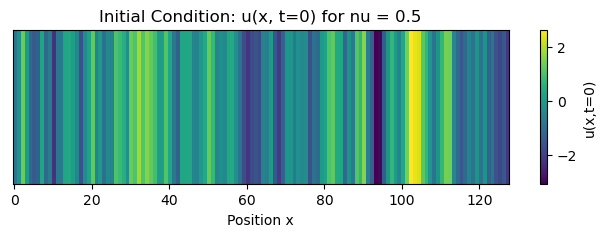

 Viscosities for train dataset: {0.10000000149011612, 0.0020000000949949026, 0.3499999940395355, 0.25, 0.006500000134110451, 0.07000000029802322, 0.4000000059604645, 0.03999999910593033, 0.0010000000474974513, 0.05000000074505806, 0.00800000037997961, 0.15000000596046448, 0.5}
 Viscosities for test dataset: {0.20000000298023224, 0.30000001192092896, 0.026896551251411438, 0.009999999776482582}
Train loader created with 724 samples
Test loader created with 123 samples


In [15]:
# ========== DATASET CONFIGURATION ==========
# Change this parameter to switch between datasets:
# - "simple": Uses BurgersDatasetSimple (one trajectory per viscosity from Data/ folder)
# - "generated": Uses BurgersViscosityDataset (multiple samples from generated_1d_burgers/ folder)

DATASET_TYPE = "alex_dataset"  # Change to "generated" to use the other dataset

batch_size = 4
history_len = 3  # Only used for "generated" dataset

# Count samples per viscosity
def count_samples_per_nu(data_dir):
    npz_files = list(data_dir.glob("*.npz"))
    nu_counts = {}
    
    for path in npz_files:
        data = np.load(path)
        nu = float(data['nu'])
        nu_counts[nu] = nu_counts.get(nu, 0) + 1
    
    return sorted(nu_counts.items())

# ========== DATASET LOADING ==========
if DATASET_TYPE == "alex_dataset":
    print("📁 Using BurgersViscosityDataset with separate train/test folders")
    # Paths to your separate train and test folders
    train_data_dir = project_root / "saved_dataset" / "generated_1d_burgers" / "train"
    test_data_dir = project_root / "saved_dataset" / "generated_1d_burgers" / "test"
    print(f"Train data directory: {train_data_dir}")
    npz_files_train = list(train_data_dir.glob("*.npz"))
    npz_files_test = list(test_data_dir.glob("*.npz"))
    # Analyze both splits
    train_counts = count_samples_per_nu(train_data_dir)
    test_counts = count_samples_per_nu(test_data_dir)
    nu_test = set()
    nu_train = set()
    for i, path in enumerate(npz_files_test):
        nu = float(np.load(path)['nu'])
        nu_test.add(nu)
    for i, path in enumerate(npz_files_train):
        data = np.load(path)['U']  # (100, T, N) - adjust key if needed
        nu = np.load(path)['nu']
        nu = float(np.load(path)['nu'])
        nu_train.add(nu)
        # print(nu)
        x = np.load(path)['x']
        t = np.load(path)['t']
        if i == len(npz_files_train) - 1:
            data_t = torch.tensor(data, dtype=torch.float32)
            nu_t = torch.tensor(nu, dtype=torch.float32)
            x_t = torch.tensor(x, dtype=torch.float32)
            t_t = torch.tensor(t, dtype=torch.float32)
            print(f"Shape of data tensor: {data_t.shape}")
            print(f"Shape of nu tensor: {nu_t.shape}")
            print(f"Shape of x tensor: {x_t.shape}")
            print(f"Shape of t tensor: {t_t.shape}")

            # VISUALIZATION OF THE FIELD:
            field_np = data_t[0].numpy()

            plt.figure(figsize=(8, 2))
            plt.imshow(field_np[np.newaxis, :], aspect='auto', cmap='viridis', interpolation='nearest')
            plt.colorbar(label='u(x,t=0)')
            plt.xlabel('Position x')
            plt.title(f"Initial Condition: u(x, t=0) for nu = {nu}")
            plt.yticks([])
            plt.show()
            
    print(f" Viscosities for train dataset: {nu_train}")
    print(f" Viscosities for test dataset: {nu_test}")


    print("\n" + "="*60)
    print("TRAINING SET - Samples per Viscosity")
    print("="*60)
    for nu, count in train_counts:
        print(f"ν = {nu:10.4f}: {count:3d} samples")

    print(f"\nTotal training samples: {sum(count for _, count in train_counts)}")
    print("\n" + "="*60)
    print("TESTING SET - Samples per Viscosity") 
    print("="*60)
    for nu, count in test_counts:
        print(f"ν = {nu:10.4f}: {count:3d} samples")

    print(f"\nTotal testing samples: {sum(count for _, count in test_counts)}")

    # Create DataLoaders
    train_loader, test_loader = create_generated_dataloaders_from_folders(
        train_dir=str(train_data_dir),
        test_dir=str(test_data_dir),
        history_len=history_len,
        batch_size=batch_size
    )

    # dataset = train_loader.dataset
    # init_field, true_traj, nu = dataset[0]
    # print(f"Sample initial field shape: {init_field.shape}")
    # print(f"Sample true trajectory shape: {true_traj.shape}")
    # print(f"Sample viscosity nu: {nu}")


    print(f"Train loader created with {len(train_loader.dataset)} samples")
    print(f"Test loader created with {len(test_loader.dataset)} samples")

    
elif DATASET_TYPE == "generated":
    print("📁 Using BurgersViscosityDataset with separate train/test folders")
    # Paths to your separate train and test folders
    train_data_dir = project_root / "saved_dataset" / "generated_1d_burgers" / "train"
    test_data_dir = project_root / "saved_dataset" / "generated_1d_burgers" / "test"
    print(f"Train data directory: {train_data_dir}")

    # Create DataLoaders
    train_loader, test_loader = create_generated_dataloaders_from_folders(
        train_dir=str(train_data_dir),
        test_dir=str(test_data_dir),
        history_len=history_len,
        batch_size=batch_size
    )

    print(f"Train loader created with {len(train_loader.dataset)} samples")
    print(f"Test loader created with {len(test_loader.dataset)} samples")

else:
    raise ValueError(f"Unknown dataset type: {DATASET_TYPE}. Use 'simple' or 'generated'")

In [16]:
# ===== Validate npz files in generated folders when using DATASET_TYPE == 'generated' =====
if DATASET_TYPE == 'generated' or DATASET_TYPE == "alex_dataset":
    print('\nRunning validate_npz_files for generated dataset')
    generated_root = project_root / 'generated_1d_burgers'
    train_dir = generated_root / 'train'
    test_dir = generated_root / 'test'

    def _print_validation(root_dir):
        print('\nValidating', root_dir)
        good, bad = validate_npz_files(str(root_dir), max_examples=None)
        print(f"  -> {len(good)} good files, {len(bad)} bad files")
        if bad:
            print('  Corrupted files (first 10 shown):')
            for b in bad[:10]:
                print('   -', b['path'])
        else:
            print('  No corrupted files detected.')
        # show unique nu values from a few good files
        nus = set()
        for g in good[:50]:
            if g['nu'] is not None:
                nus.add(round(float(g['nu']), 12))
        print('  nu values (from inspected files):', sorted(list(nus)))

    if train_dir.exists():
        _print_validation(train_dir)
    else:
        print('  Train directory not found:', train_dir)

    if test_dir.exists():
        _print_validation(test_dir)
    else:
        print('  Test directory not found:', test_dir)



Running validate_npz_files for generated dataset
  Train directory not found: c:\Dev\CentralSupelec\BDRP\ML_Differential_Solver\generated_1d_burgers\train
  Test directory not found: c:\Dev\CentralSupelec\BDRP\ML_Differential_Solver\generated_1d_burgers\test


Sample 657 | nu=0.5000
 initial_field: torch.Size([128])
 trajectory   : torch.Size([256, 128])


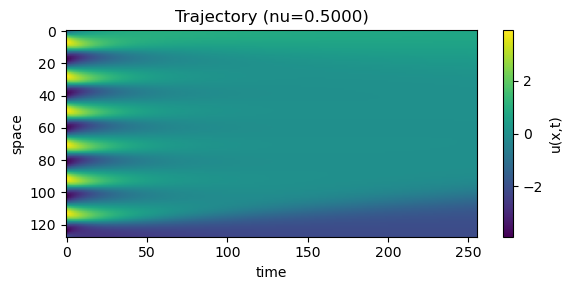

We consider 128 spatial positions per trajectory
We consider 256 time snapshots per trajectory


In [17]:
# For generated dataset, show sample from the training set
dataset = train_loader.dataset
init_field, true_traj, nu = dataset[0]
if hasattr(dataset, 'dataset'):  # Handle random_split wrapper
    dataset = dataset.dataset
idx = np.random.randint(0, len(dataset))
show_random_sample(dataset, idx)

T, N = true_traj.shape
print(f"We consider {N} spatial positions per trajectory")
print(f"We consider {T} time snapshots per trajectory")

### Load model

In [18]:
# Model configuration
patch_radius = 1
patch_size = 2 * patch_radius + 1
chunk_size = 5

LOAD_MODEL_NAME = None

# --- Transformer --- #
# model = TransformerController(patch_size=patch_size, hidden_size=64)

# --- CNN -----
# model = CNNController(
#     field_size = N
# ).to(device)

# Model Initialization
# model = CNNController(N, WINDOW_SIZE, corr_clip=0.15).to(device)
# # Optimizer Initialization
# optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
# if DATASET_TYPE == "alex_dataset":
#     num_epochs = 30
#     rollout_depth_max = T - WINDOW_SIZE - 1
    
#     print(f"Using device: {device}")
#     print(f"Model: Recurrent CNN (Trainable Params: {sum(p.numel() for p in model.parameters() if p.requires_grad)})")



# --- Load a saved model # 
LOAD_MODEL_NAME = "transformers.pth"  # Set to filename like "my_model.pth" to load a model

if LOAD_MODEL_NAME is not None:
    print(f"📥 Loading model from: {LOAD_MODEL_NAME}")
    model = torch.load(models_dir / LOAD_MODEL_NAME, map_location=device, weights_only=False)
    print(f"✓ Model loaded successfully")

model = model.to(device)

print(f"Model information:")
print(f"  - Patch radius: {patch_radius}")
print(f"  - Patch size: {patch_size}")
print(f"  - Number of parameters: {sum(p.numel() for p in model.parameters())}")
print(f"\nModel architecture:")
print(model)

📥 Loading model from: transformers.pth
✓ Model loaded successfully
Model information:
  - Patch radius: 1
  - Patch size: 3
  - Number of parameters: 8770

Model architecture:
TransformerController(
  (embed): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
  )
  (attn): Linear(in_features=64, out_features=1, bias=True)
  (fc_out): Sequential(
    (0): ReLU()
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)


### Model training

In [21]:
num_epochs = 1

print(f"🚀 Starting training for {num_epochs} epochs with {DATASET_TYPE} dataset...")
print("=" * 60)

DATASET_TYPE = "generated"
# training_mode = "alex_dataset"

if DATASET_TYPE == "alex_dataset":
    # Train recurrent CNN with stability enhancements
    model, history = training_cnn(model, train_loader, optimizer, num_epochs, WINDOW_SIZE, rollout_depth_max)
    train_losses = history.get("loss", [])
    training_mode = "CNN Controller"
    # Evaluation
    final_metrics = evaluate_model(model, test_loader, WINDOW_SIZE, T_MAX)

elif DATASET_TYPE == "generated":
    # Train transformer/RNN variant
    train_losses = train_rnn_patch(
        model=model,
        dataloader=train_loader,
        device=device,
        patch_radius=patch_radius,
        num_epochs=num_epochs,
        chunk_size=chunk_size,   # utilisé seulement pour les modèles séquentiels
    )
    training_mode = "RNN Patch"
else:
    raise ValueError(f"Unknown DATASET_TYPE={DATASET_TYPE}")

print(f"\n Training completed!")
print(f" Dataset used : {DATASET_TYPE}")
print(f" Model        : {model.__class__.__name__}")
print(f" Mode         : {training_mode}")
final_loss = train_losses[-1] if train_losses else float('nan')
print(f" Final loss   : {final_loss:.6f}")

🚀 Starting training for 1 epochs with alex_dataset dataset...


KeyboardInterrupt: 

### Loss funciton

In [22]:
plot_losses(train_losses)

print(f"Final loss: {train_losses[-1]:.6f}")
print(f"Loss reduction: {((train_losses[0] - train_losses[-1])/train_losses[0]*100):.2f}%")

NameError: name 'train_losses' is not defined

## Visualization

In [32]:
# Choose a single nu target to use for both visualization and evaluation
# Supported values: float (e.g. 0.01), 'min', 'max', 'idx:N', 'random', 'list', or None
PLOT_NU = 'random'  # change this value to pick a specific sample or 'list' for available nus

# Resolve selected_nu once and store it globally
eval_loader = test_loader if test_loader is not None else train_loader
loader_type = "test" if test_loader is not None else "train"

print(f"🎯 Resolving nu target using loader: {loader_type} and PLOT_NU={PLOT_NU}")
selected_nu = resolve_nu_target(eval_loader, plot_nu=PLOT_NU, selected_nu=None, list_nus=True, verbose=True)

if selected_nu is None:
    print("No specific nu selected; visualization/evaluation will use default (first sample from loader).")
else:
    print(f"Global selected_nu set: {selected_nu}")


🎯 Resolving nu target using loader: test and PLOT_NU=random
Loader contains 4 unique nu values: [0.009999999776482582, 0.026896551251411438, 0.20000000298023224, 0.30000001192092896]
Global selected_nu set: 0.026896551251411438


🔍 Generating predictions using test data...
Using selected nu target for visualization: 0.026896551251411438
Generating predictions for nu = 0.0269
True trajectory shape: torch.Size([256, 128])
Model type: TransformerController
  step 0/251
  step 10/251
  step 20/251
  step 30/251
  step 40/251
  step 50/251
  step 60/251
  step 70/251
  step 80/251
  step 90/251
  step 100/251
  step 110/251
  step 120/251
  step 130/251
  step 140/251
  step 150/251
  step 160/251
  step 170/251
  step 180/251
  step 190/251
  step 200/251
  step 210/251
  step 220/251
  step 230/251
  step 240/251
  step 250/251


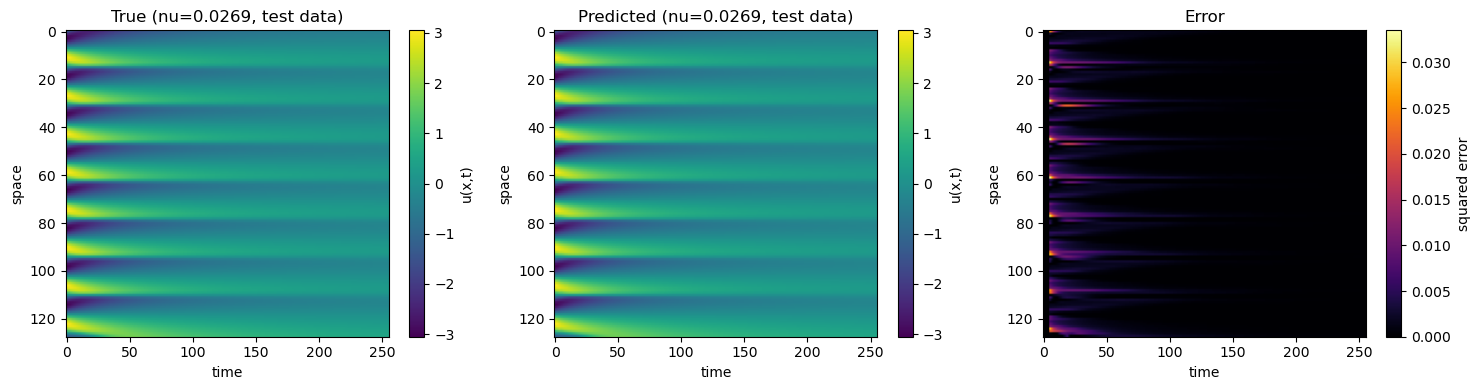

In [33]:
# Generate predictions for visualization
# Use test_loader if available, otherwise fall back to train_loader

# Use the selected_nu set by the single selection cell above if present
selected_nu_local = globals().get('selected_nu', None)

eval_loader = test_loader if test_loader is not None else train_loader
loader_type = "test" if test_loader is not None else "train"

print(f"🔍 Generating predictions using {loader_type} data...")

if selected_nu_local is None:
    print("No global selected_nu set; the first sample from the loader will be used for visualization (nu_target=None).")
else:
    print(f"Using selected nu target for visualization: {selected_nu_local}")

true_traj, pred_traj, nu_value = generate_model_predictions(
    model, 
    eval_loader, 
    device, 
    patch_radius, 
    verbose=True, 
    chunk_size=chunk_size,
    nu_target=selected_nu_local,
    list_nus=False,
    fallback_to_first=True,
)

# Visualize trajectories
plot_trajectories(true_traj, pred_traj, title_suffix=f" (nu={nu_value:.4f}, {loader_type} data)")


## Evaluation

📊 Evaluating model performance on test data...
Using selected nu target for evaluation: 0.20000000298023224
Evaluation metrics:
  - PSNR: 38.192 dB
  - SSIM: 0.992
  - MSE: 0.000152
  - R²: 0.9980


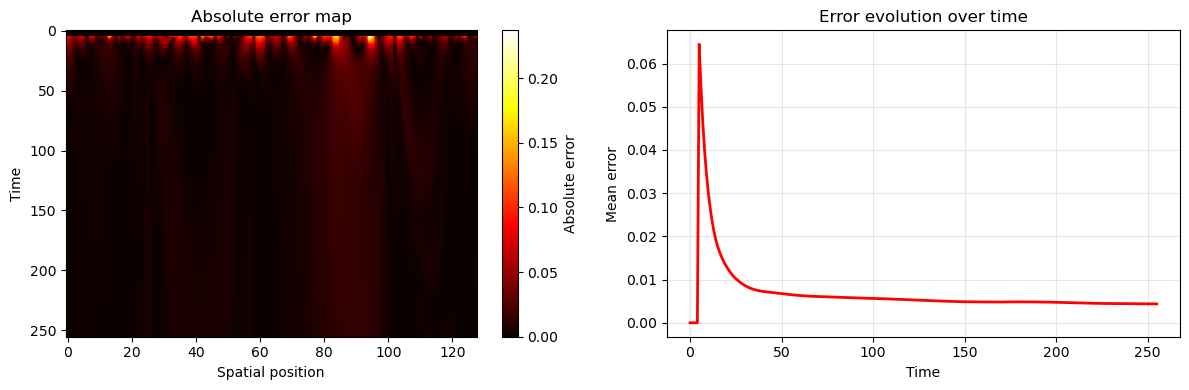

In [25]:
# Complete evaluation with dedicated function
# Use test_loader if available, otherwise fall back to train_loader
eval_loader = test_loader if test_loader is not None else train_loader
loader_type = "test" if test_loader is not None else "train"

print(f"📊 Evaluating model performance on {loader_type} data...")

# Use the same selected nu set by the single selection cell (selected_nu)
selected_nu_local = globals().get('selected_nu', None)

# Do not call resolve_nu_target here - central selection is in the single cell
if selected_nu_local is None:
    eval_nu_target = None
    print("No global selected_nu set for evaluation; using default (first sample from loader).")
else:
    eval_nu_target = selected_nu_local
    print(f"Using selected nu target for evaluation: {eval_nu_target}")

evaluation_results = evaluate_model_on_sample(
    model,
    eval_loader,
    device,
    patch_radius,
    max_val=1.0,
    val_range=1.0,
    chunk_size=chunk_size,
    nu_target=eval_nu_target,
)

# Display results with dedicated function
true_traj, pred_traj = display_evaluation_results(evaluation_results, show_plots=True)


## Mean Absolute Error (MAE) Formula

The Mean Absolute Error at time $t$ is defined as:

$$E(t) = \frac{1}{N} \sum_{x=1}^{N} |u_{\text{true}}(t, x) - u_{\text{pred}}(t, x)|$$

**Where:**
- $N$ is the number of spatial points
- $u_{\text{true}}(t, x)$ is the true solution at time $t$ and position $x$
- $u_{\text{pred}}(t, x)$ is the predicted solution at time $t$ and position $x$
- $| \cdot |$ denotes the absolute value

---

This formula calculates the average absolute difference between the true and predicted solutions across all spatial points at a given time step, providing a measure of prediction accuracy.

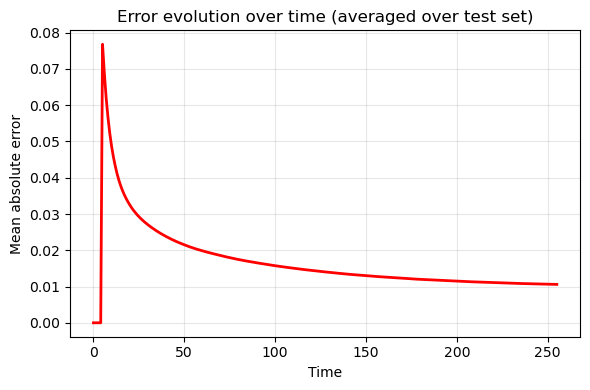

Mean error_per_time shape: (256,)


In [26]:
if test_loader is not None:
    mean_error_per_time = error_evolution_on_loader(
        model,
        test_loader,
        device,
        patch_radius=patch_radius,
        chunk_size=chunk_size,
        show_plot=True,   # met à False si tu veux juste les valeurs
    )
    print(f"Mean error_per_time shape: {mean_error_per_time.shape}")
else:
    print("No test loader available; skipping test set evaluation.")

## Field for CNN
### conv1-field
How the model read the past values of u(t,f)

### conv1-nu
How the viscosity influence the local prediction

### conv2-field
How the second layer combine modification ectract with conv1 for the output

### filter 0
Individual kernel

In [ ]:
# conv1 : vue sur le champ (canal "field")
plot_space_time_kernel(model, layer_name="conv1", channel_type="field", out_channel=None)

# conv1 : même chose mais filtre 0 (c’est le seul, mais ça marche)
plot_space_time_kernel(model, layer_name="conv1", channel_type="field", out_channel=0)

# si tu veux voir l’impact de nu sur cette même couche
plot_space_time_kernel(model, layer_name="conv1", channel_type="nu", out_channel=None)

# tu peux aussi jeter un œil aux kernels de conv2 (une seule entrée, donc pas de 'nu')
plot_space_time_kernel(model, layer_name="conv2", channel_type="field", out_channel=None)


plot_space_time_kernel: le modèle n'a pas de couche 'conv1'. Rien à afficher.
plot_space_time_kernel: le modèle n'a pas de couche 'conv1'. Rien à afficher.
plot_space_time_kernel: le modèle n'a pas de couche 'conv1'. Rien à afficher.
plot_space_time_kernel: le modèle n'a pas de couche 'conv2'. Rien à afficher.


### Save Model

In [ ]:
# # ========== MODEL SAVING ==========
# SAVE_MODEL_NAME = "my_trained_model.pth"  

# if SAVE_MODEL_NAME is not None:
#     print(f"💾 Saving model to: {SAVE_MODEL_NAME}")
#     torch.save(model, models_dir / SAVE_MODEL_NAME)
#     print(f"✓ Model saved successfully to: {models_dir / SAVE_MODEL_NAME}")
# else:
#     print("ℹ️  To save the model, set SAVE_MODEL_NAME = 'filename.pth'")
#     print(f"   Models will be saved to: {models_dir}")

In [ ]:
# 🔎 Debug: display unique nu values in train/test loaders
try:
    if 'test_loader' in globals() and test_loader is not None:
        print("Test loader unique nu values:", get_loader_nu_values(test_loader))
    if 'train_loader' in globals() and train_loader is not None:
        print("Train loader unique nu values:", get_loader_nu_values(train_loader))
except Exception as e:
    print("Unable to inspect loader nus:", e)

Train loader unique nu values: [0.0010000000474974513, 0.009999999776482582, 0.10000000149011612, 0.5]
